In [523]:
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import*

from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
import numpy as np

In [454]:
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 384
BATCH_SIZE = 10
CHANNELS = 3

In [455]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'new_data',
    shuffle=True,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE
)

Found 933 files belonging to 4 classes.


In [456]:
class_names = dataset.class_names
class_names

['compost', 'e-waste', 'recycle', 'trash']

In [457]:
stage_2_classification = {
    'battery': 'e-waste',
    'biological': 'compost',
    'cardboard': 'compost',
    'brown-glass': 'recycle',
    'green-glass': 'recycle',
    'white_glass': 'recycle',
    'metal': 'recycle',
    'paper': 'recycle',
    'plastic': 'recycle',
    'trash': 'trash'
}

In [458]:
len(dataset)

94

In [459]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)

# output: 10 images in batch, each image is 512x384, 3 color channels (RGB)

(10, 512, 384, 3)


In [460]:
for image_batch, label_batch in dataset.take(1):
    print(label_batch)

# output: the class labels for the first 10 images

tf.Tensor([2 3 1 2 0 0 2 2 1 0], shape=(10,), dtype=int32)


In [461]:
def display_first_ten_images():
    
    plt.figure(figsize=(10,10))
    for image_batch, label_batch in dataset.take(1):
        for i in range(10):
            ax = plt.subplot(2,5,i+1)
            plt.imshow(image_batch[i].numpy().astype(int))
            plt.title(class_names[label_batch[i]])
            plt.axis('off')

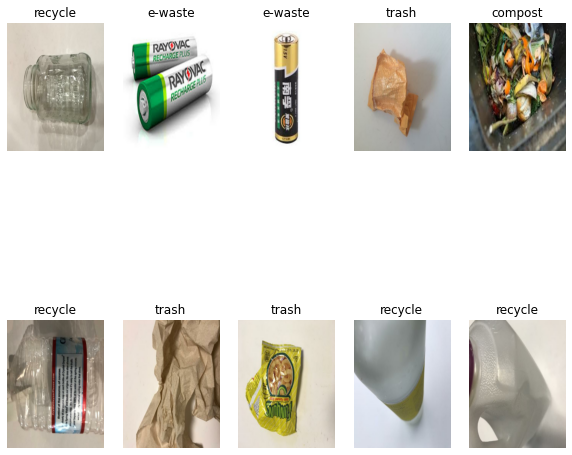

In [462]:
display_first_ten_images()

### create train-test-validation split

In [463]:
def create_train_test_validation_splits(data, shuffle=True, shuffle_size=10000):
    
    # shuffle data before splitting data
    if shuffle:
        data = data.shuffle(shuffle_size, seed=6)
    
    train_split = 0.8
    test_split = 0.1
    val_split = 0.1
    
    train_size = int(train_split * len(data))
    test_size = int(test_split * len(data))
    
    # create partitioned datasets
    train = data.take(train_size)
    test = data.skip(train_size).take(test_size)
    val = data.skip(train_size).skip(test_size)
    
    return train, test, val

In [464]:
train, test, val = create_train_test_validation_splits(dataset)

In [465]:
print(f'train size: {len(train)} batches')
print(f'test size: {len(test)} batches')
print(f'validation size: {len(val)} batches')

train size: 75 batches
test size: 9 batches
validation size: 10 batches


In [466]:
# optimizing datasets for training performance
train = train.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

### Pre-processing

In [467]:
# create pre-processing pipeline

prepoc = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    
    # data augmentation
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')
])

In [479]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)

model = Sequential([
    prepoc,
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2,2)),
    #Conv2D(64, kernel_size=(3,3), activation='relu'),
    #MaxPooling2D((2,2)),
    Flatten(),
    #BatchNormalization(axis=1),
    Dense(len(class_names), activation='softmax')
])

In [480]:
model.build(input_shape=INPUT_SHAPE)

In [481]:
model.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_71 (Sequential)  (None, 512, 384, 3)       0         
                                                                 
 conv2d_76 (Conv2D)          (10, 510, 382, 32)        896       
                                                                 
 max_pooling2d_78 (MaxPoolin  (10, 255, 191, 32)       0         
 g2D)                                                            
                                                                 
 flatten_56 (Flatten)        (10, 1558560)             0         
                                                                 
 dense_63 (Dense)            (10, 4)                   6234244   
                                                                 
Total params: 6,235,140
Trainable params: 6,235,140
Non-trainable params: 0
___________________________________________

In [482]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [483]:
history = model.fit(
    train,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val
)

Epoch 1/20
75/75 [==============================] - 42s 543ms/step - loss: 14.2503 - accuracy: 0.4805 - val_loss: 1.0108 - val_accuracy: 0.6200
Epoch 2/20
75/75 [==============================] - 39s 515ms/step - loss: 1.0021 - accuracy: 0.6447 - val_loss: 0.7266 - val_accuracy: 0.7400
Epoch 3/20
75/75 [==============================] - 39s 522ms/step - loss: 0.7448 - accuracy: 0.7281 - val_loss: 0.8128 - val_accuracy: 0.7700
Epoch 4/20
75/75 [==============================] - 39s 516ms/step - loss: 0.7739 - accuracy: 0.7497 - val_loss: 0.8201 - val_accuracy: 0.7500
Epoch 5/20
75/75 [==============================] - 42s 561ms/step - loss: 0.5893 - accuracy: 0.7847 - val_loss: 0.6236 - val_accuracy: 0.8400
Epoch 6/20
75/75 [==============================] - 55s 740ms/step - loss: 0.5753 - accuracy: 0.8008 - val_loss: 0.5906 - val_accuracy: 0.8800
Epoch 7/20
75/75 [==============================] - 47s 630ms/step - loss: 0.4487 - accuracy: 0.8452 - val_loss: 0.4498 - val_accuracy: 0.880

In [484]:
scores = model.evaluate(test)

9/9 [==============================] - 4s 139ms/step - loss: 0.2110 - accuracy: 0.9556


In [485]:
scores

[0.2109558880329132, 0.9555555582046509]

In [489]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 75}

In [490]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [491]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

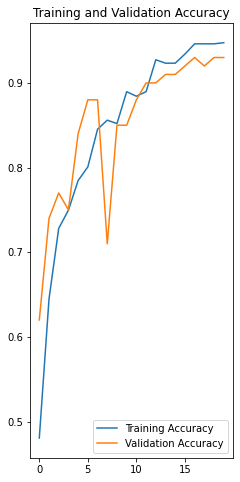

In [493]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

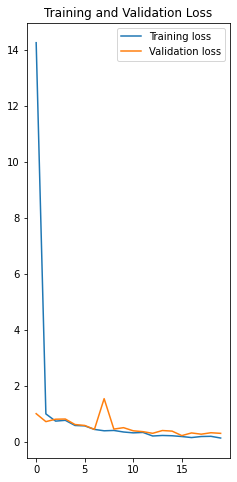

In [495]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(20), loss, label='Training loss')
plt.plot(range(20), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [542]:
model.save('./models/production')

INFO:tensorflow:Assets written to: ./models/production/assets


In [581]:
[class_names[np.argmax(model.predict(test)[i])] for i in range(len(model.predict(test)))]

['recycle',
 'e-waste',
 'compost',
 'recycle',
 'recycle',
 'trash',
 'recycle',
 'trash',
 'recycle',
 'trash',
 'compost',
 'trash',
 'trash',
 'recycle',
 'e-waste',
 'trash',
 'compost',
 'e-waste',
 'e-waste',
 'trash',
 'compost',
 'recycle',
 'recycle',
 'recycle',
 'recycle',
 'recycle',
 'compost',
 'compost',
 'compost',
 'trash',
 'recycle',
 'trash',
 'recycle',
 'compost',
 'recycle',
 'recycle',
 'e-waste',
 'recycle',
 'e-waste',
 'compost',
 'compost',
 'recycle',
 'trash',
 'compost',
 'recycle',
 'compost',
 'compost',
 'compost',
 'e-waste',
 'recycle',
 'compost',
 'recycle',
 'compost',
 'compost',
 'recycle',
 'recycle',
 'compost',
 'recycle',
 'e-waste',
 'recycle',
 'compost',
 'recycle',
 'trash',
 'recycle',
 'recycle',
 'trash',
 'e-waste',
 'e-waste',
 'recycle',
 'compost',
 'compost',
 'recycle',
 'recycle',
 'recycle',
 'compost',
 'recycle',
 'compost',
 'e-waste',
 'compost',
 'compost',
 'compost',
 'trash',
 'recycle',
 'recycle',
 'recycle',
 'recy